#Creating a CNN model from scratch using pytorch and fastai for Face Mask Detection

Importing necessary libraries

In [ ]:
!pip install -Uqq fastbook
import fastbook

     |████████████████████████████████| 727kB 28.6MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 194kB 57.3MB/s 
     |████████████████████████████████| 1.2MB 57.3MB/s 
     |████████████████████████████████| 61kB 10.3MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 


In [ ]:
from fastai.vision.all import *
from fastbook import *

Loading the dataloaders object for training our model

In [ ]:
dls = load_pickle('dls.pkl')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


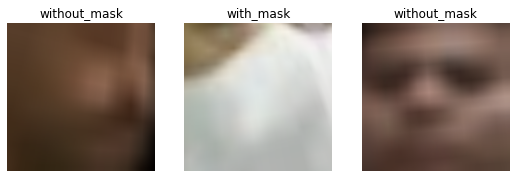

In [ ]:
dls.train.show_batch(max_n=3)

In [ ]:
X, y = dls.train.one_batch()
X.shape, y.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

Building our CNN model consisting of two convolution layers and two linear layers

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.cnn_layers = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3),
        nn.BatchNorm2d(12),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3),
        nn.BatchNorm2d(12),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.linear_layers = nn.Sequential(
        nn.Linear(34992, 50),
        nn.Linear(50, 3)
    )

  def forward(self, x):
    x = self.cnn_layers(x)
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)
    return x

In [ ]:
model = Model()

In [ ]:
model.parameters

<bound method Module.parameters of Model(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=34992, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=3, bias=True)
  )
)>

Using Adam as optimizer and Crossentropyloss for categorical classification

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
torch.cuda.is_available()

True

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() 
                                   else "cpu")
model.to(device)
criterion.to(device)

CrossEntropyLoss()

Training our model for a number of epochs

In [ ]:
train_losses, valid_losses = [], []

def train(epochs):

  for epoch in range(epochs):
    for inputs, labels in dls.train:
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss = loss.item()

    model.eval()
    with torch.no_grad():
      for inputs_val, labels_val in dls.valid:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs_val = model(inputs_val)
        loss_val = criterion(outputs_val, labels_val)
        valid_loss = loss_val.item()
        
        prob = F.softmax(outputs_val, dim=1)
        pred = torch.argmax(prob, dim=1)
        equals = torch.where(pred == labels_val, 1, 0)
        acc = torch.mean(equals.float())
        
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Epoch {epoch+1}/{epochs}')
    print(f'Train loss: {train_loss}')

    print(f'Valid loss: {valid_loss}') 

    print(f'Valid accuracy: {acc}')

In [ ]:
train(5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/5
Train loss: 0.9216433167457581
Valid loss: 3.2538552284240723
Valid accuracy: 0.8571429252624512
Epoch 2/5
Train loss: 0.15444603562355042
Valid loss: 0.3781547248363495
Valid accuracy: 0.8571429252624512
Epoch 3/5
Train loss: 0.44394415616989136
Valid loss: 0.4706466495990753
Valid accuracy: 0.8571429252624512
Epoch 4/5
Train loss: 0.3677673041820526
Valid loss: 0.2677217125892639
Valid accuracy: 0.9285714626312256
Epoch 5/5
Train loss: 0.32719871401786804
Valid loss: 0.3214196562767029
Valid accuracy: 0.9285714626312256


Evaluating our training losses and validation losses

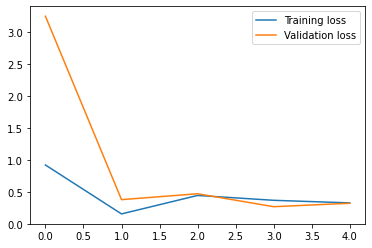

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()
plt.show()

We see that the validation loss stabilizes at the end of the first epoch. So, one epoch is probably enough to train our model.

Checking our model on a single image

In [ ]:
img = Image.open('mask.jpg')

Preparing the image to input into our model

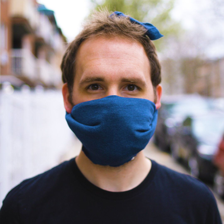

In [ ]:
img = img.resize((224,224))
img

In [ ]:
imgtens = tensor(img)

In [ ]:
imgtens = imgtens.unsqueeze(0)

In [ ]:
imgtens = imgtens.reshape(1,3,224,224)
imgtens = imgtens.float()

Getting the prediction

In [ ]:
with torch.no_grad():
  outputs = model(imgtens.cuda())

  prob = F.softmax(outputs, dim=1)
  pred = dls.vocab[torch.argmax(prob)]
  

In [ ]:
pred

'with_mask'

Our model predicted this image correctly!

Saving the model for future use

In [ ]:
save_pickle('modelfromscratch.pkl', Model)